In [229]:
import sys
import os
import glob
import json
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np

In [230]:
def find_files(path):
    return glob.glob(path)

In [231]:
def read_json(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

## Adatok olvasása
Adatok beolvasása JSON fájlként, majd egy nagy pandas-os DataFrame-mé alakítása.

In [232]:
json_data = []

for file in find_files('Data/*'):
    print("Reading file:", file)
    json_data.append(read_json(file))
    
data_frame = pd.DataFrame()

for data in json_data:
    frames  = [data_frame, pd.DataFrame(data)]
    data_frame = pd.concat(frames).reset_index(drop=True)

Reading file: Data/gyakori_szamitastechnika
Reading file: Data/gyakori_egeszseg_20000
Reading file: Data/gyakori_szorakozas_30000
Reading file: Data/gyakori_egeszseg
Reading file: Data/gyakori_allatok_14000


## Bepillantás a kérdésekbe
Csak hogy tudjuk pontosan mivel is állunk szemben. Minden kérdéshez tartozik a kérdés rövid, illetve hosszú verziója, egy válasz, amit a felhasználók a leghasznosabbnak találtak. Ezeken kívül kategóriák és kulcsszavak is vannak a kérdéshez.

In [233]:
data_frame.head(2)

,valasz,kategoriak,hosszu_kerdes,rovid_kerdes,keywords
0,Várak régen is voltak. Ha mindhárom tornyot le...,"[Számítástechnika, Internet]",Miért lett ilyen sz@r a honfoglaló? Régen tök ...,Miért lett ilyen sz@r a honfoglaló?,"[Honfoglaló, vár]"
1,"Ahogy írták, az stdio az a C-s függvénykönyvtá...","[Számítástechnika, Programozás]",C++-ban melyiket érdemesebb használni? Stdio v...,C++-ban melyiket érdemesebb használni? Stdio v...,"[C++, iostream, konzol, Windows, Visual Studio]"


## Átlagos hossz, extrém esetek szűrése
Az extrém hosszú vagy rövid kérdések nem túl hasznosak. Érdemes őket kiszűrni. Az átlagostól sokkal eltérő kérdéseket nem használjuk a továbbiakban.

In [234]:
def calculate_avg(data_frame, label="rovid_kerdes"):
    l = data_frame[label].tolist()
    return sum(map(len, l)) / len(l)

def drop_extreme(data_frame, min_, max_, label="rovid_kerdes"):
    data_frame = data_frame[data_frame[label].map(len) >= min_]
    data_frame = data_frame[data_frame[label].map(len) <= max_]

    return data_frame

In [235]:
long_questions_avg_len = calculate_avg(data_frame, "hosszu_kerdes")
print("Average length: %f" % long_questions_avg_len)

Average length: 346.495816


In [236]:
data_frame = drop_extreme(data_frame, long_questions_avg_len / 4, long_questions_avg_len * 3, "hosszu_kerdes")
long_questions_avg_len = calculate_avg(data_frame, "hosszu_kerdes")

print("Average length: %f" % long_questions_avg_len)

Average length: 326.753950


## "Főkategóriák" kigyűjtése
Az egyes főkategóriák neveinek kigyűjtése, majd az egyes nevekhez egy azonosító szám rendelése.

In [237]:
target_names = data_frame['kategoriak'].apply(lambda x: x[0]).unique().tolist()
target_dict =  {value: key for key, value in enumerate(target_names)}

num_of_categories = len(target_names)

print(target_names)
print(target_dict)

['Számítástechnika', 'Egészség', 'Szórakozás', 'Állatok']
{'Számítástechnika': 0, 'Egészség': 1, 'Szórakozás': 2, 'Állatok': 3}


## Tanító adathalmaz előállítása
A tanító adathalmazban minden egyes főkategóriából ugyanannyi kérdésnek kell szerepelnie (így fair). Itt pontosan ez történik `questions_from_each_category` darab kérdés kerül a tanító adathalmazba minden kategóriából, majd az eredményül kapott tömb véletlenszerűen összekeveredik.

#### Shuffle together
A shuffle_together függvény két listát véletlenszerűen kever össze, úgy, hogy az a keverés előtt az egyes listákban azonos indexen szereplő értékek a keverés után is azonos indexen lesznek.

In [238]:
def shuffle_together(list1, list2):
    zipped = list(zip(list1, list2))
    random.shuffle(zipped)
    list1, list2 = zip(*zipped)
    
    return (list(list1), list(list2))

In [239]:
train_ratio = 0.80
test_ratio = 1.0 - train_ratio

min_amount = float('inf')

for target_name in target_names:
    amount = len(data_frame[data_frame["kategoriak"].apply(lambda x : x[0]) == target_name]['kategoriak'])
    min_amount = min(amount, min_amount)

train_each_ctg = int(min_amount * train_ratio)
test_each_ctg = int(min_amount * test_ratio)

In [240]:
import random

train_size = train_each_ctg * num_of_categories
train_questions = []
train_target = []

test_size = test_each_ctg * num_of_categories
test_questions = []
test_target = []

# Shuffle rows
data_frame = data_frame.sample(frac=1).reset_index(drop=True)


for target_name in target_names:
    train_questions += data_frame[data_frame["kategoriak"].apply(lambda x: x[0]) == target_name][0:train_each_ctg]["hosszu_kerdes"].to_list()
    train_target += [target_dict[target_name]] * train_each_ctg    
    
    test_questions += data_frame[data_frame["kategoriak"].apply(lambda x: x[0]) == target_name][train_each_ctg:train_each_ctg + test_each_ctg]["hosszu_kerdes"].to_list()
    test_target += [target_dict[target_name]] * test_each_ctg    
   
train_questions, train_target = shuffle_together(train_questions, train_target)
test_questions, test_target = shuffle_together(test_questions, test_target)

In [241]:
def unicode_to_ascii(data):
    return unidecode.unidecode(re.sub(r"[,.;@#?!&$]+\ *", " ", data).lower()).split()

In [242]:
import unidecode
import re
from collections import Counter

vocab = set()

for idx, q in enumerate(train_questions):
    words = unicode_to_ascii(q)

    for idx in range(len(words)):
        vocab.add(words[idx])

    train_questions[idx] = " ".join(words)

vocab_size = len(vocab)

index_to_word = {}

for idx, word in enumerate(vocab):
    index_to_word[word] = idx

In [243]:
def get_batch(text, target, i, batch_size, input_size, index_to):

    batches = []
    results = []
    
    texts = text[i * batch_size : i * batch_size + batch_size]
    categories = target[i * batch_size : i * batch_size + batch_size]

    for text in texts:
        layer = np.zeros(input_size , dtype=float)
        words = unicode_to_ascii(text)
        
        for idx in range(len(words)):
            if words[idx] in index_to:
                layer[index_to[words[idx]]] += 1
            
        batches.append(layer)
        
    for category in categories:
        results.append(category)
     
    return np.array(batches), np.array(results)

In [244]:
learning_rate = 0.01
num_epochs = 2
batch_size = 200

hidden_size = 100
input_size = vocab_size
num_classes = len(target_names)

In [245]:
from torch.autograd import Variable
import torch.nn as nn
import torch

In [246]:
class BOWClassification(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(BOWClassification, self).__init__()
        self.layer_1 = nn.Linear(input_size, hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)
 
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

In [247]:
net = BOWClassification(vocab_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  


for epoch in range(num_epochs):
    if epoch:
        print()
    print("Epoch %d/%d: " % (epoch + 1, num_epochs))
    total_batch = len(train_questions) // batch_size
    for i in range(total_batch):
        batch_x, batch_y = get_batch(train_questions, train_target, i, batch_size, vocab_size, index_to_word)
        questions = Variable(torch.FloatTensor(batch_x))
        themes = Variable(torch.LongTensor(batch_y))
        
        optimizer.zero_grad()
        outputs = net(questions)
        loss = criterion(outputs, themes)
        loss.backward()
        optimizer.step()
        
        print("\r[%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")

Epoch 1/2: 
[321/321] 100.00%
Epoch 2/2: 
[321/321] 100.00%

In [248]:
total_batch = test_size // batch_size

total_pred = []

for i in range(total_batch):
    test_batch_x, test_batch_y = get_batch(test_questions, test_target, i, batch_size, vocab_size, index_to_word)
    print("\rTesting... [%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")
    
    questions = Variable(torch.FloatTensor(test_batch_x))
    themes = Variable(torch.FloatTensor(test_batch_y))
    
    outputs = net(questions)
    _, predicted = torch.max(outputs.data, 1)
    total_pred += predicted.tolist()

Testing... [80/80] 100.00%

## Tesztelés eredémye

### Confusion matrix
Tévesztési mátrix magyarul. A mátrix `i` sorában, `j` oszlopában szereplő érték (ebben az esetben) azt jelenti, hogy a mondat a `i` kategóriájú, de a háló `j` kategóriát ismert fel.

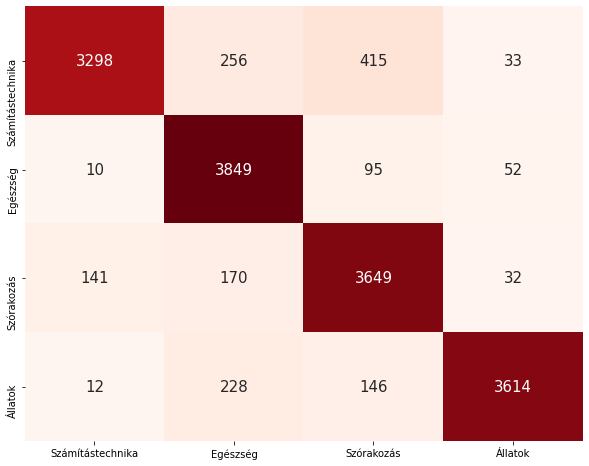

In [251]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_target[0:len(total_pred)], total_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

plt.figure(figsize = (10,8))
heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
plt.show()

In [254]:
from sklearn.metrics import classification_report

class_report = classification_report(test_target[0:len(total_pred)], total_pred, target_names=target_names)
print(class_report)

                  precision    recall  f1-score   support

Számítástechnika       0.95      0.82      0.88      4002
        Egészség       0.85      0.96      0.90      4006
      Szórakozás       0.85      0.91      0.88      3992
         Állatok       0.97      0.90      0.93      4000

        accuracy                           0.90     16000
       macro avg       0.91      0.90      0.90     16000
    weighted avg       0.91      0.90      0.90     16000



## Alkategória osztályozás

In [255]:
target_names_subctg = {}
target_dict_subctg = {}

for mainctg in target_names:
    mainctg_rows = data_frame[data_frame["kategoriak"].apply(lambda x : x[0]) == mainctg]
    list_of_subctg = mainctg_rows["kategoriak"].apply(lambda x : x[1]).unique().tolist()

    target_dict_subctg[mainctg] = {value: key for key, value in enumerate(list_of_subctg)}
    target_names_subctg[mainctg] = list_of_subctg


In [256]:
min_amount_subctg = {}
train_each_subctg = {}
test_each_subctg = {}

num_of_subcategories = {}

for mainctg in target_names:
    
    num_of_subcategories[mainctg] = len(target_names_subctg[mainctg])
    
    min_amount = float('inf')
    for subctg in target_names_subctg[mainctg]:
        amount = len(data_frame[data_frame["kategoriak"].apply(tuple) == (mainctg, subctg)]["kategoriak"])
        min_amount = min(min_amount, amount)

    min_amount_subctg[mainctg] = min_amount
    train_each_subctg[mainctg] = int(min_amount * train_ratio)
    test_each_subctg[mainctg] = int(min_amount * test_ratio)

In [257]:
train_questions_subctg = {}
train_size_subctg = {}
train_target_subctg = {}

test_questions_subctg = {}
test_size_subctg = {}
test_target_subctg = {}

for mainctg in target_names:
    
    train_size_subctg[mainctg] = train_each_subctg[mainctg] * num_of_subcategories[mainctg]
    test_size_subctg[mainctg] = test_each_subctg[mainctg] * num_of_subcategories[mainctg]
    
    for subctg in target_names_subctg[mainctg]:
        if mainctg not in train_questions_subctg:
            train_questions_subctg[mainctg] = []
            train_target_subctg[mainctg] = []
            test_questions_subctg[mainctg] = []
            test_target_subctg[mainctg] = []

        train_questions_subctg[mainctg] += data_frame[data_frame["kategoriak"].apply(tuple) == (mainctg, subctg)][0:train_each_subctg[mainctg]]["hosszu_kerdes"].to_list()
        train_target_subctg[mainctg] += [target_dict_subctg[mainctg][subctg]] * train_each_subctg[mainctg] 
        
        test_questions_subctg[mainctg] += data_frame[data_frame["kategoriak"].apply(tuple) == (mainctg, subctg)][train_each_subctg[mainctg]:train_each_subctg[mainctg] + test_each_subctg[mainctg]]["hosszu_kerdes"].to_list()
        test_target_subctg[mainctg] += [target_dict_subctg[mainctg][subctg]] * test_each_subctg[mainctg] 

    train_questions_subctg[mainctg], train_target_subctg[mainctg] = shuffle_together(train_questions_subctg[mainctg], train_target_subctg[mainctg])
    test_questions_subctg[mainctg], test_target_subctg[mainctg] = shuffle_together(test_questions_subctg[mainctg], test_target_subctg[mainctg])

In [258]:
vocab_subctg = {}
vocab_size_subctg = {}
index_to_word_subctg = {}

for mainctg in target_names:
    vocab_subctg[mainctg] = set()
    
    for idx, q in enumerate(train_questions_subctg[mainctg]):
        words = unicode_to_ascii(q)
        
        for idx in range(len(words)):
            vocab_subctg[mainctg].add(words[idx])
            
        train_questions_subctg[mainctg][idx] = " ".join(words)
    
    vocab_size_subctg[mainctg] = len(vocab_subctg[mainctg])

    index_to_word_subctg[mainctg] = {}
    
    for idx, word in enumerate(vocab_subctg[mainctg]):
        index_to_word_subctg[mainctg][word] = idx

In [259]:
learning_rate = 0.05
num_epochs = 5
batch_size = 50

hidden_size = 200

In [ ]:
net_subctg = {}

for mainctg in target_names:
    print(mainctg)
    net_subctg[mainctg] = BOWClassification(vocab_size_subctg[mainctg], hidden_size, num_of_subcategories[mainctg])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net_subctg[mainctg].parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        print("Epoch %d/%d: " % (epoch + 1, num_epochs))
        total_batch = train_size_subctg[mainctg] // batch_size
        
        for i in range(total_batch):
            batch_x, batch_y = get_batch(train_questions_subctg[mainctg], train_target_subctg[mainctg], i, batch_size, vocab_size_subctg[mainctg], index_to_word_subctg[mainctg])
            questions = Variable(torch.FloatTensor(batch_x))
            themes = Variable(torch.LongTensor(batch_y))

            optimizer.zero_grad()
            outputs = net_subctg[mainctg](questions)
            loss = criterion(outputs, themes)
            loss.backward()
            optimizer.step()
            
            print("\r[%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")
        print()

Számítástechnika
Epoch 1/5: 
[72/72] 100.00%
Epoch 2/5: 
[72/72] 100.00%
Epoch 3/5: 
[72/72] 100.00%
Epoch 4/5: 
[72/72] 100.00%
Epoch 5/5: 
[72/72] 100.00%
Egészség
Epoch 1/5: 
[57/57] 100.00%
Epoch 2/5: 
[57/57] 100.00%
Epoch 3/5: 
[57/57] 100.00%
Epoch 4/5: 
[57/57] 100.00%
Epoch 5/5: 
[57/57] 100.00%
Szórakozás
Epoch 1/5: 
[109/109] 100.00%
Epoch 2/5: 
[109/109] 100.00%
Epoch 3/5: 
[109/109] 100.00%
Epoch 4/5: 
[109/109] 100.00%
Epoch 5/5: 
[32/109] 29.36%

In [ ]:
total_pred_subctg = {}

for mainctg in target_names:
    total_batch = test_size_subctg[mainctg] // batch_size
    total_pred_subctg[mainctg] = []
    print(mainctg)
    
    for i in range(total_batch):
        test_batch_x, test_batch_y = get_batch(test_questions_subctg[mainctg], test_target_subctg[mainctg], i, batch_size, vocab_size_subctg[mainctg], index_to_word_subctg[mainctg])
        print("\rTesting... [%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")

        questions = Variable(torch.FloatTensor(test_batch_x))
        themes = Variable(torch.FloatTensor(test_batch_y))

        outputs = net_subctg[mainctg](questions)
        _, predicted = torch.max(outputs.data, 1)
        total_pred_subctg[mainctg] += predicted.tolist()
    print()

In [ ]:
for mainctg in target_names:
    cm = confusion_matrix(test_target_subctg[mainctg][0:len(total_pred_subctg[mainctg])], total_pred_subctg[mainctg])
    cm_df = pd.DataFrame(cm, index=target_names_subctg[mainctg], columns=target_names_subctg[mainctg])

    plt.figure(figsize = (10,8))
    heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
    plt.show()


In [ ]:
for mainctg in target_names:
    class_report = classification_report(test_target_subctg[mainctg][0:len(total_pred_subctg[mainctg])], total_pred_subctg[mainctg], target_names=target_names_subctg[mainctg])
    print(class_report)